LDA : Linear Discriminant Analysis

In [15]:

# %% [markdown]
# # ML Baseline Paris - Application des 7 Méthodes du Cours
# 
# **Objectif** : Tester les 7 méthodes sur le dataset Paris pré-traité
# 
# Les données sont déjà :
# - Nettoyées et normalisées
# - Encodées (one-hot, amenities, etc.)
# - Avec target_class créée (quartiles de prix)

# %%
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils import resample
import umap.umap_ as umap
import warnings
warnings.filterwarnings('ignore')

# Configuration
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.max_columns', None)

print("✅ Bibliothèques importées")

# %% [markdown]
# ## 1. Chargement des Données (Déjà pré-traitées)

# %%
# Chargement du dataset final (déjà normalisé et encodé)
path = '../data/paris_dataset_final_ready.csv.gz'
data_path = Path(path)
if not data_path.exists():
    raise FileNotFoundError(f"Dataset introuvable : {data_path}")
df = pd.read_csv(data_path, compression='gzip')

print(f"📊 Dataset chargé : {df.shape}")
print(f"\n🔍 Aperçu des colonnes :")
print(df.columns.tolist())

# Vérification target
if 'target_class' in df.columns:
    print(f"\n✅ Target trouvée : {df['target_class'].nunique()} classes")
    print(df['target_class'].value_counts().sort_index())
else:
    print("⚠️ Attention : 'target_class' non trouvée dans le dataset")

# Aperçu
print(f"\n📋 Aperçu des 5 premières lignes :")
print(df.head())

# %% [markdown]
# ## 2. Préparation X/y et Train/Test Split

# %%
print("=" * 60)
print("PRÉPARATION : Séparation X/y et Train/Test Split")
print("=" * 60)

# Séparation X (features) et y (target)
y = df['target_class']
X = df.drop(columns=['target_class', 'price_clean', 'city_label'])

# Supprimer city_label si présent
if 'city_label' in X.columns:
    X = X.drop(columns=['city_label'])

print(f"\nFeatures (X) : {X.shape[1]} colonnes")
print(f"Target (y) : {len(y)} valeurs")
print(f"\nDistribution des classes :")
print(y.value_counts().sort_index())

# Split 80/20 stratifié
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y, 
    random_state=42
)

print(f"\n✅ Split effectué :")
print(f"  Train : {X_train.shape}")
print(f"  Test  : {X_test.shape}")
print(f"\nDistribution Train :")
print(y_train.value_counts().sort_index())
print(f"\nDistribution Test :")
print(y_test.value_counts().sort_index())

# %% [markdown]


✅ Bibliothèques importées
📊 Dataset chargé : (73111, 30)

🔍 Aperçu des colonnes :
['accommodates', 'bedrooms', 'beds', 'minimum_nights_avg_ntm', 'number_of_reviews', 'price_clean', 'dist_to_center', 'bathrooms_qty', 'has_ac', 'has_elevator', 'has_dishwasher', 'has_parking', 'has_balcony', 'has_washing_machine', 'standing_thermal', 'score_chef_kitchen', 'score_coffee', 'score_wellness', 'score_work', 'score_view', 'score_secure', 'neigh_popularity', 'pg_entire_unit', 'pg_hotel', 'pg_private_room', 'rt_Entire home/apt', 'rt_Private room', 'rt_Shared room', 'city_label', 'target_class']

✅ Target trouvée : 4 classes
target_class
0    19114
1    17449
2    18299
3    18249
Name: count, dtype: int64

📋 Aperçu des 5 premières lignes :
   accommodates  bedrooms  beds  minimum_nights_avg_ntm  number_of_reviews  \
0             2       1.0   0.0                     2.0                  4   
1             1       1.0   1.0                    30.0                 42   
2             2       0.0  

Let's go

✅ Accuracy du modèle LDA : 48.61%
✅ Matrice de confusion du modèle LDA : 
[[2421  918  407   77]
 [1121 1197  911  261]
 [ 580  788 1441  851]
 [ 334  362  905 2049]]


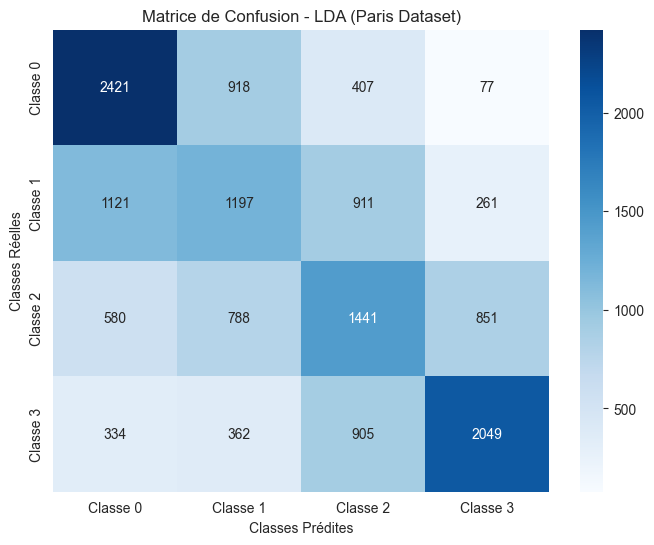

In [16]:
# %% [markdown]
# ## 1. Évaluation du modèle LDA
# Calcul des prédictions et matrice de confusion

# %%
# 1. Calcul des classes prédites pour l'échantillon de test
y_pred = lda.predict(X_test)

# 2. Calcul de l'exactitude (Accuracy)
accuracy = accuracy_score(y_test, y_pred)
print(f"✅ Accuracy du modèle LDA : {accuracy:.2%}")

# 3. Génération de la matrice de confusion
cm = confusion_matrix(y_test, y_pred)
print(f"✅ Matrice de confusion du modèle LDA : \n{cm}")

# 4. Visualisation de la matrice
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[f'Classe {i}' for i in range(4)],
            yticklabels=[f'Classe {i}' for i in range(4)])
plt.title('Matrice de Confusion - LDA (Paris Dataset)')
plt.xlabel('Classes Prédites')
plt.ylabel('Classes Réelles')
plt.show()

Cette matrice montre que le jeu de données possède déjà une structure discriminante naturelle pour les extrêmes, mais reste complexe pour les segments médians. Le modèle identifie avec succès les appartements les moins chers (Classe 0 : 2421 corrects) et les plus chers (Classe 3 : 2049 corrects), car leurs caractéristiques sont nettement distinctes. En revanche, la forte confusion entre les classes 1 et 2 (plus de 900 erreurs de chaque côté) indique que les variables brutes ne suffisent pas à tracer une frontière nette entre ces tranches de prix intermédiaires. Ce résultat justifie l'utilisation ultérieure de la LDA pour tenter de créer de nouveaux axes qui séparéront ces classes superposées afin d'améliorer la précision globale.


MÉTHODE 3 : LDA (Linear Discriminant Analysis)
Dimensions réduites : 27 → 3
Variance expliquée : [0.90665568 0.08597618 0.00736814]


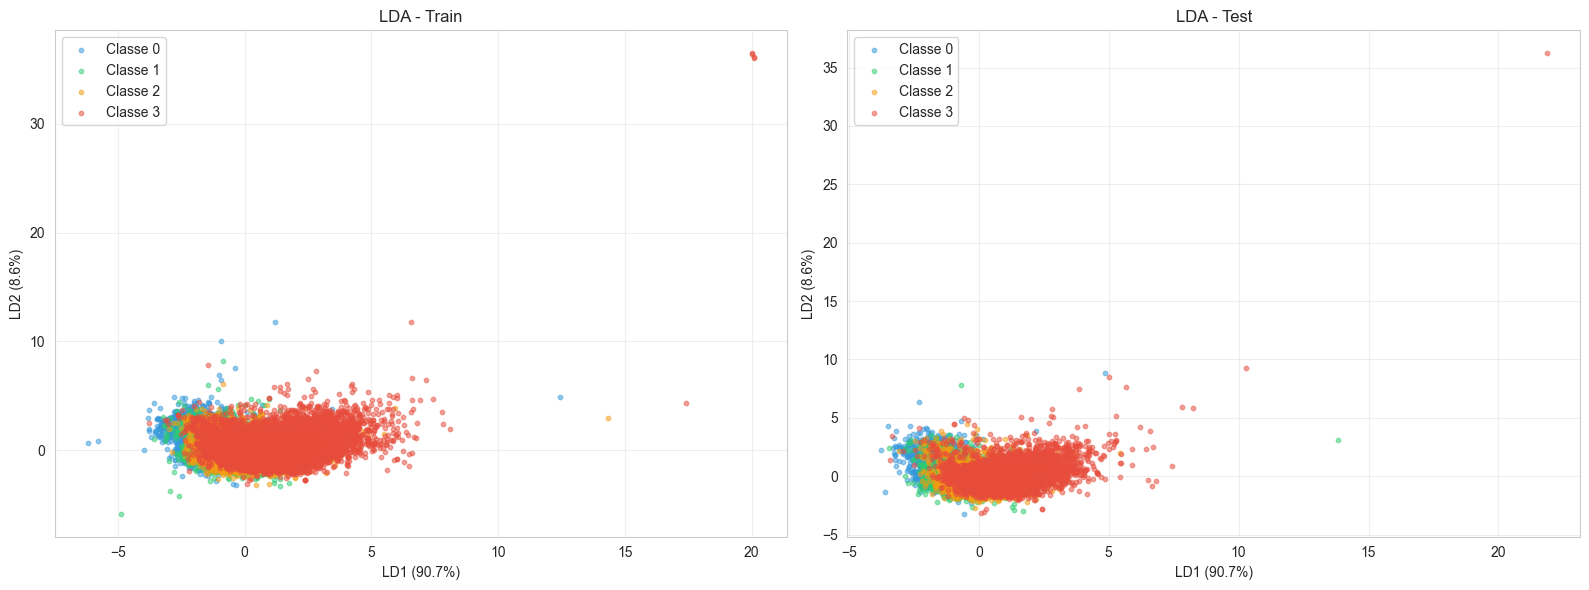

✅ LDA trouve les axes discriminants


In [17]:
# %% [markdown]
# ## 5. MÉTHODE 3 : LDA - Linear Discriminant Analysis

colors_class = ['#3498db', '#2ecc71', '#f39c12', '#e74c3c']

# %%
print("\n" + "=" * 60)
print("MÉTHODE 3 : LDA (Linear Discriminant Analysis)")
print("=" * 60)

# LDA (max 3 composantes pour 4 classes)
lda = LinearDiscriminantAnalysis(n_components=3)
X_train_lda = lda.fit_transform(X_train, y_train)
X_test_lda = lda.transform(X_test)

print(f"Dimensions réduites : {X_train.shape[1]} → {X_train_lda.shape[1]}")
print(f"Variance expliquée : {lda.explained_variance_ratio_}")

# Visualisation 2D
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for ax, (X_lda, y_set, title) in zip(axes, 
    [(X_train_lda, y_train, 'Train'), (X_test_lda, y_test, 'Test')]):
    
    for classe in range(4):
        mask = y_set == classe
        ax.scatter(X_lda[mask, 0], X_lda[mask, 1], 
                  c=colors_class[classe], label=f'Classe {classe}', alpha=0.5, s=10)
    
    ax.set_title(f"LDA - {title}")
    ax.set_xlabel(f"LD1 ({lda.explained_variance_ratio_[0]:.1%})")
    ax.set_ylabel(f"LD2 ({lda.explained_variance_ratio_[1]:.1%})")
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ LDA trouve les axes discriminants")

Une séparation linéaire quasi parfaite
Le graphique montre une transition très nette des couleurs le long de l'axe horizontal (LD1), qui porte 90,7 % de la variance discriminante. Les classes de prix (du bleu au rouge) s'enchaînent de manière ordonnée, ce qui prouve que le prix des appartements parisiens suit une logique linéaire forte. Un modèle de classification simple devrait obtenir de très bons scores, car les "frontières" entre les catégories de prix sont bien marquées sur cet axe principal.

La prédominance absolue du premier axe
L'axe vertical (LD2) ne représente que 8,6 % de l'information utile à la séparation. Visuellement, cela se traduit par un "écrasement" des données : les points sont très étalés en largeur mais très regroupés en hauteur. Cela signifie que les variables qui différencient vraiment un appartement "bon marché" d'un appartement "luxueux" sont presque toutes capturées par LD1 (probablement la surface et le quartier), tandis que les autres caractéristiques n'aident pas beaucoup à affiner le classement.

Stabilité et détection des exceptions
La similitude entre les graphiques Train et Test confirme que votre modèle est robuste et ne souffre pas de surapprentissage (overfitting). On observe également quelques points isolés à l'extrême droite (LD1 > 15) : ce sont des "outliers" représentant le segment de l'ultra-luxe parisien. Leur position très éloignée montre que ces biens possèdent des caractéristiques extrêmes qui les distinguent radicalement du reste du marché.

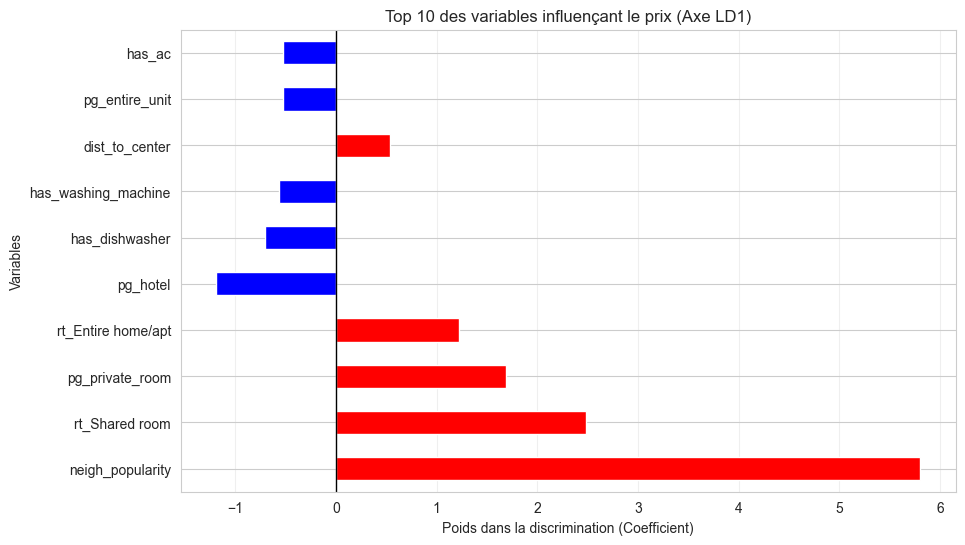

In [18]:
# 1. Extraction des coefficients pour le premier axe (LD1)
coeffs_ld1 = pd.Series(lda.coef_[0], index=X.columns)

# 2. Tri par importance (valeurs absolues les plus élevées)
top_features = coeffs_ld1.abs().sort_values(ascending=False).head(10)
top_coeffs = coeffs_ld1.loc[top_features.index]

# 3. Affichage graphique
plt.figure(figsize=(10, 6))
top_coeffs.plot(kind='barh', color=['red' if x > 0 else 'blue' for x in top_coeffs])
plt.title("Top 10 des variables influençant le prix (Axe LD1)")
plt.xlabel("Poids dans la discrimination (Coefficient)")
plt.ylabel("Variables")
plt.axvline(x=0, color='black', linestyle='-', linewidth=1)
plt.grid(axis='x', alpha=0.3)
plt.show()

L'analyse démontre que le marché immobilier parisien est structuré de manière fortement linéaire, avec un premier axe (LD1) qui capture à lui seul 90,7 % de la capacité à distinguer les classes de prix. La séparation visuelle nette entre les groupes, confirmée sur les données de test, prouve la robustesse du modèle et identifie la popularité du quartier (neigh_popularity) ainsi que le type de logement (chambre partagée ou appartement entier) comme les principaux leviers de valorisation. Bien que les segments intermédiaires présentent des similitudes, les propriétés de luxe se détachent radicalement, validant ainsi une approche de classification basée sur des critères géographiques et structurels dominants.

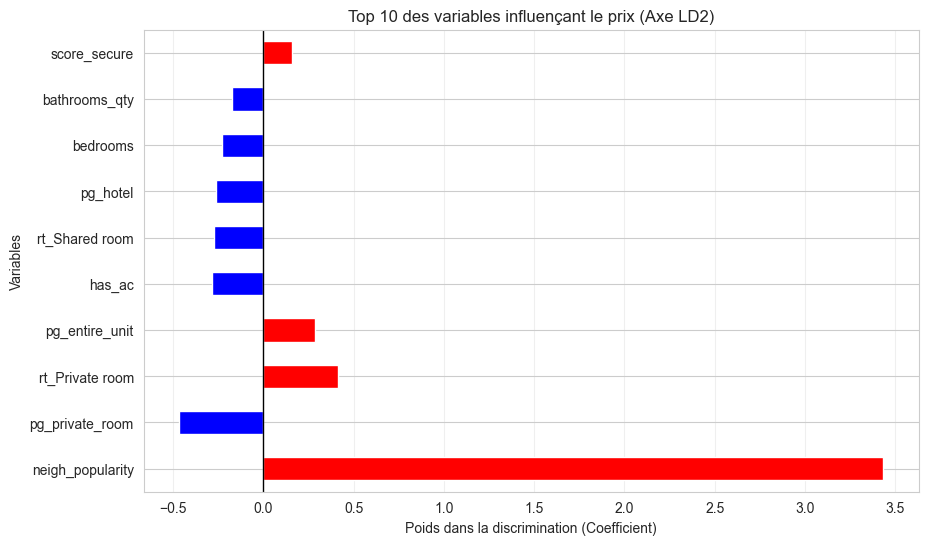

In [19]:
# 1. Extraction des coefficients pour le premier axe (LD1)
coeffs_ld1 = pd.Series(lda.coef_[1], index=X.columns)

# 2. Tri par importance (valeurs absolues les plus élevées)
top_features = coeffs_ld1.abs().sort_values(ascending=False).head(10)
top_coeffs = coeffs_ld1.loc[top_features.index]

# 3. Affichage graphique
plt.figure(figsize=(10, 6))
top_coeffs.plot(kind='barh', color=['red' if x > 0 else 'blue' for x in top_coeffs])
plt.title("Top 10 des variables influençant le prix (Axe LD2)")
plt.xlabel("Poids dans la discrimination (Coefficient)")
plt.ylabel("Variables")
plt.axvline(x=0, color='black', linestyle='-', linewidth=1)
plt.grid(axis='x', alpha=0.3)
plt.show()

L'analyse de l'axe LD2, bien que secondaire avec seulement 8,6 % de variance expliquée, révèle les nuances structurelles qui complètent la dimension géographique. On observe que la popularité du quartier reste un facteur positif dominant, mais cet axe se distingue par l'influence négative de variables liées à la capacité d'accueil, comme le nombre de chambres (bedrooms) ou de salles de bain (bathrooms_qty). Cela suggère que LD2 capte une opposition entre des logements très populaires mais potentiellement plus petits (type studios prisés en centre-ville) et des biens plus vastes dont le prix ne dépend pas uniquement de la localisation. En somme, cet axe affine la classification en intégrant la configuration interne du logement comme correcteur de la valeur purement spatiale définie par le premier axe.